In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [3]:
path = '/content/drive/MyDrive/Finding and Measuring Lung In CT Data/2d_images.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_images')

path = '/content/drive/MyDrive/Finding and Measuring Lung In CT Data/2d_masks.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_masks')
    


In [4]:
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


In [5]:
IMG_SIZE = 256
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

In [6]:
for i, img_path in enumerate(img_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    x_data[i] = img


In [7]:
for i, img_path in enumerate(mask_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    y_data[i] = img

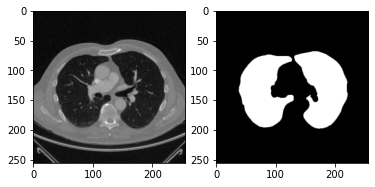

In [8]:
x_data /= 255
y_data /= 255

# display samples of image and mask in gray scale
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[0].squeeze(), cmap='gray')
ax[1].imshow(y_data[0].squeeze(), cmap='gray')
# ^ since imshow takes 2d array, 3d array is squeezed down to 2d by removing single dimensional entry

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(213, 256, 256, 1)
(54, 256, 256, 1)


In [10]:
inputs = Input(shape=(256, 256, 1))

# encoding
net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

# decoding
net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)

# output with 1 channel for gray scale segmenation
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

# use binary cross entropy with sigmoid function 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-05)

# train model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=32, callbacks=[reduce_lr])

Epoch 1/30
7/7 [==============================] - 116s 16s/step - loss: 0.7095 - acc: 0.6686 - mse: 0.2344 - val_loss: 0.6553 - val_acc: 0.7455 - val_mse: 0.2046 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - 115s 16s/step - loss: 0.5809 - acc: 0.7516 - mse: 0.1874 - val_loss: 0.5799 - val_acc: 0.7377 - val_mse: 0.1928 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - 116s 17s/step - loss: 0.5572 - acc: 0.7480 - mse: 0.1829 - val_loss: 0.5498 - val_acc: 0.7455 - val_mse: 0.1805 - lr: 0.0010
Epoch 4/30
7/7 [==============================] - 114s 16s/step - loss: 0.5374 - acc: 0.7526 - mse: 0.1754 - val_loss: 0.5318 - val_acc: 0.7454 - val_mse: 0.1737 - lr: 0.0010
Epoch 5/30
7/7 [==============================] - 111s 16s/step - loss: 0.5183 - acc: 0.7520 - mse: 0.1675 - val_loss: 0.5088 - val_acc: 0.7454 - val_mse: 0.1654 - lr: 0.0010
Epoch 6/30
7/7 [==============================] - 110s 16s/step - loss: 0.4826 - acc: 0.7525 - mse: 0.1550 - val_loss: 0.4564

In [12]:
model.save('image_segmentation.model')

INFO:tensorflow:Assets written to: image_segmentation.model/assets


Text(0.5, 0, 'epoch')

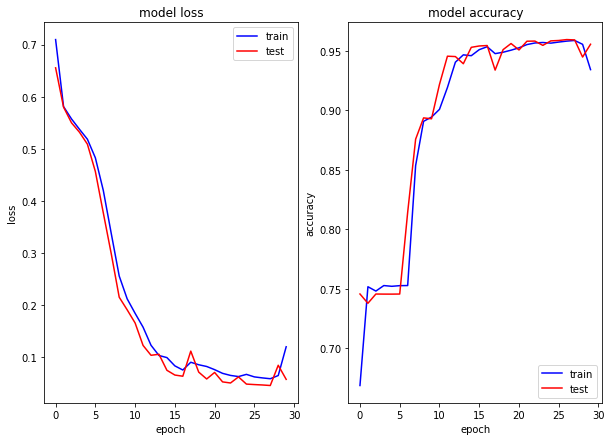

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history.history['loss'], 'b')
ax[0].plot(history.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history.history['acc'], 'b')
ax[1].plot(history.history['val_acc'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

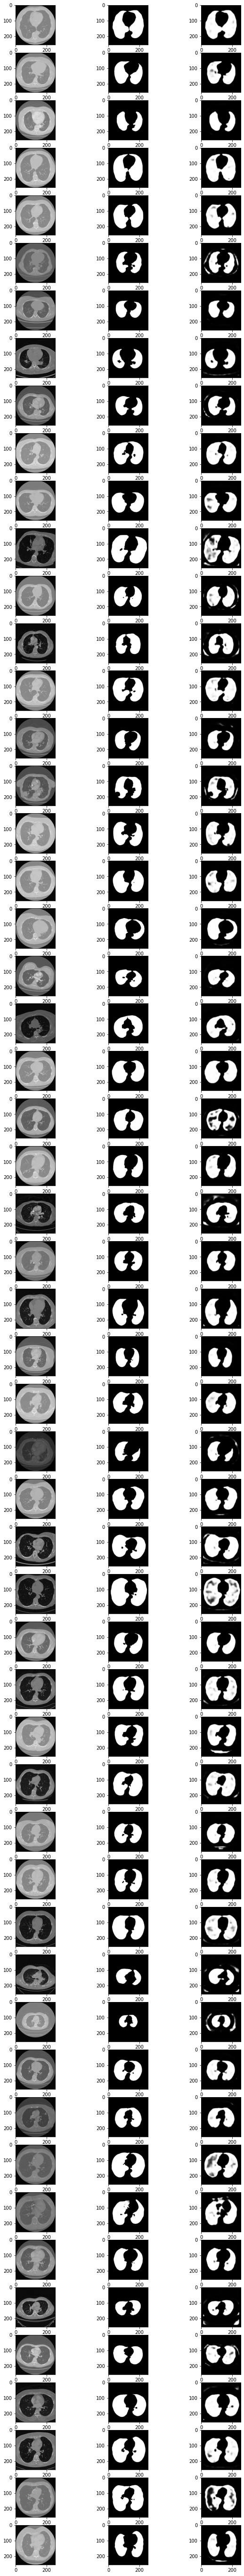

In [14]:
# predict segmentation
preds = model.predict(x_val)

# show results
fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))
for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')